# ISMI2018 Lymphocyte Detection Project
This is the main notebook for the final ISMI2018 project by Group 6.


*Detection of lymphocytes in histopathology whole-slide images of breast, colon and prostate cancer, stained with immunohistochemistry*

### Team 6
Our group consists out of four people:
* **Brian Westerweel (Data Science)** - `B.Westerweel@student.ru.nl`
* **Christoph Schmidl (Data Science)** - `c.schmidl@student.ru.nl`
* **Gijs van der Meijde (Software Science)** - `G.vanderMeijde@student.ru.nl`
* **Jeffrey Luppus (Data Science)** - `J.Luppes@student.ru.nl`

*Supervisor: Francesco Ciompi*

Group Github page: https://github.com/jeffluppes/ISMI2018 *feel free to work in branches.*

* ```x``` = unavailable this date (e.g. unable to work on anything)
* ```-``` = reduced availability (e.g. you might be able to skype or work a couple of hours)

| Name  | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | *Notes* |
|-------|---|---|---|---|---|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|---------|
| Jeff  | - | - | x | x | x |  - |  - |  - |  - |    |  - |    |    |    |    |    |    |    |  x |    |    | *2 hrs a day for pet projects during work days, internship ends 15th* |
| Gijs  | x | x | x | x | x |  x |  x |  x |  x |  x |  - |    |    |    |  - |  - |  - |    |    |    |    | *has short term deadline until the 13th*        |
| Brian |   |   |   | - | - |  x |  x |  - |  - |  - |  - |  x |  x |  - |  - |  - |  - | x  |  x |  x |    |         |
| Chris |   |   |   |   |   |    |  x |  x |  x |  x |    |    |    |    |  x |  x |  x |    |    |    |    |         | 


I took Gijs's attendance from what he said this morning. Mine is based around my internship (ends the 15th)

## Goals for this week (June 11 to June 18)

**MAIN GOALS**
* Use all of the training and validation data that we have available
* Implement a function to return the coordinates of a mask (centroid calculation)
* Saving predictions (images) to disk
* Make a submission file
* Use generator and make sensible augmentations
* Make annotations
* Make our first submission
* Dont be lazy

**Other goals:**

* Implement loss plotting function
* Implement early stopping
* Implement a custom loss function
* Run predictions on the entire validation set

**Backlog and minor TODOs**
* Implement image warping
* Get data augmentation working
* Implement a function to count lymphocytes

Be aware of the following:

* **Next contact moment**: Monday at 10 skype call > New moment to be scheduled
* **Next group meeting**: Friday and Monday


## Important Deadlines

* ~~<font color='red'>**Mid-term presentation:** June 4, 9:00 - 12:00, room 616 Huygen building</font>~~
* Deadline project: 25th of june
* **Final presentation:** July 2, 9:00 - 12:00, room 616 Huygen building


## Resources
The two papers Francesco sent:

* https://openreview.net/pdf?id=rk0xLisiM
* https://openreview.net/pdf?id=S10IfW2oz

Kaggle Contest about cell detection (Data Science Bowl 2018)

* https://www.kaggle.com/c/data-science-bowl-2018

Particular Kernels of Interest (KoIs)

* https://www.kaggle.com/weiji14/yet-another-keras-u-net-data-augmentation
* https://www.kaggle.com/piotrczapla/tensorflow-u-net-starter-lb-0-34
* https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855

Other resources

* https://spark-in.me/post/unet-adventures-part-one-getting-acquainted-with-unet
* https://towardsdatascience.com/medical-image-segmentation-part-1-unet-convolutional-networks-with-interactive-code-70f0f17f46c6 (Christoph)
* https://colab.research.google.com/drive/1BgCDxVdVc0MAe_kC0waMGUV9ShcWW0hM (Christoph)
* https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/ (Jeff)
* https://github.com/jocicmarko/ultrasound-nerve-segmentation (Jeff)
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/ (Gijs)

### MOOCs if you have spare time to waste (I havent)
http://course.fast.ai/part2.html
http://course.fast.ai/lessons/lesson14.html

In [1]:
# System
from os.path import join, basename, dirname, exists  
import os  
from glob import glob
import csv
import random 
from tqdm import tqdm
from PIL import Image
Image.MAX_IMAGE_PIXELS = 2201136600 #because Pillow will whine to no end if you feed it big images. You're welcome.


# Computational
import pandas as pd  
import numpy as np  
from matplotlib import pyplot as plt  

# Keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Input, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dropout, UpSampling2D, core
from keras.callbacks import ModelCheckpoint


# Other
import seaborn as sns
import skimage
from scipy.ndimage import imread  
from IPython.display import clear_output
from sklearn.metrics import precision_recall_curve

Using TensorFlow backend.


## 0.1 Tracking time
This tracks the computation time for the entire notebook. See results in the last cell.


In [2]:
import time
start_time = time.time()

In [3]:
user = 'ruc0028' # Jeffrey = True
#user = 'ruc0030' # Gijs = True

## Cartesius file paths

In [4]:
train_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/train_images'
validation_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_images'
test_dir = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/test_images'
train_points = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/training_annotations.csv'
validation_points = '/projects/0/ismi2018/FINALPROJECTS/LYMPHOCYTE_DETECTION/validation_annotations.csv' #new
data_dir = 'data'
train_masks_dir = data_dir+'/train_masks'
validation_masks_dir = data_dir+'/validation_masks'
results_dir = 'Results'

num_channels = 3  #changing this breaks the entire thing but just so you know we include it as an option. 

gen_patches = False #Whether or not you want to generate new patches. Keep false to use patches stored on disk
train_patches_dir = data_dir+'/train_patches'
validation_patches_dir = data_dir+'/validation_patches'

In [5]:
# read in train csv and show what we've got
train_annotations = pd.read_csv(train_points, index_col=False)
train_annotations.describe()

,roi_id,pixel_size,x,y,score
count,50811.000000,50811.000000,50811.000000,50811.000000,50811.0
mean,3.810966,0.237240,1896.588442,1407.527356,1.0
std,2.654371,0.026024,1688.602631,1286.433055,0.0
min,1.000000,0.121547,3.398438,4.304688,1.0
25%,2.000000,0.243094,744.808594,574.351562,1.0
50%,3.000000,0.243094,1435.830078,1067.398438,1.0
75%,5.000000,0.243094,2549.500000,1872.800781,1.0
max,23.000000,0.243094,15101.097656,14209.000000,1.0


**What to gather from this?**

We have 50811 points, the pixel sizes vary from 0.12 to 0.24 but the mean is much closer to 0.24 indicating a skewed distribution. Yet, it's good to keep in mind the varying sizes!

### Some statistics on the training data
So the annotations file has the locations of each annotated cell. It would be good to know how many lymphocytes per ROI we can expect. The below query produces an ordered list per image and ROI of how many annotations we have per combination.

In [6]:
# get annotations per image, bear in mind this only actually obtains the ROIs that have lymphocytes
# note: this specifically returns a dataframe instead of a series so we can plot it with ease
df = train_annotations.groupby([' roi_id','image_id']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df.index.name = 'Combination_id'
df.head(10)

,roi_id,image_id,counts
Combination_id,,,
33,1,T3C02L1A1B1S11R01,2052
133,4,T1C02L1A1B1S11R01,1258
78,3,35_CD8,1045
16,1,95-30827-5_CD3,905
9,1,37_CD3,842
89,3,T10-4360_I_AG_CD3,804
66,2,T2C02L1A1B1S11R01,799
107,4,12-CD3_27.11.2014_17.27.31,789
22,1,T17-071549_III5_CD3,749


## If the jupyter server runs locally (Brian, Gijs)

In [7]:
#ttrain_dir = 'train_images'
#ttrain_masks_dir = 'train_masks'
#train_points = 'training_annotations.csv'

# Part 1 - Housekeeping
This section defines the convenience methods needed for processing the images.

* Creating various masks (used as ground truth)
    * Square Masks
    * Elipse Masks
    * Circular Masks
    * Mask creation
* Creating patches
    * Patch generation
* Data augmentation generator

### 1.1 Creating Masks

In [8]:
def split(x):
    return x.split(', ')

def createSquareMask(h, w, center, radius):
    mask = np.zeros((h, w), dtype=bool)
    lb = center[0] - radius
    rb = center[0] + radius
    ub = center[1] - radius
    bb = center[1] + radius
    mask[ub:bb, lb:rb] = True
    return mask

def createElipseMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + 2*(Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def createCircularMask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
    

def createMaskForImage(img_dir, image_path, center_csv, mask_dir, mask_fn):
    image_name = image_path.split('.png')[0]
    image_id, roi = image_name.split('_ROI_')
    print('Processing {}'.format(image_name))
    
    image = plt.imread(join(img_dir, image_path))
    mask = np.zeros((image.shape[0], image.shape[1]))
    pixel_size = 0.24309392273426056 # is this the same for each image?
     
    radius = 2.5 / pixel_size #Brian's was 3.5.
    
    pois = []
    with open(center_csv) as file:
        pois = list(map(split, file.readlines()[1:]))
    
    pois = [poi for poi in pois if (poi[0] == image_id and poi[1] == roi)]

    
    print('Found {} lymphocytes in this image.'.format(len(pois))) # How many lymps are annotated here?
    for poi in pois:
        x = int(float(poi[3]))
        y = int(float(poi[4]))
        shape_mask = mask_fn(image.shape[0], image.shape[1], [x, y], radius)
        mask[shape_mask] = 1
        
    mask_image = Image.fromarray(np.uint8(mask*255), 'L')
    mask_image.save(join(mask_dir, image_name + '_mask.png'))
    print('Created a mask for: {}'.format(image_name))

In [9]:
training_paths = os.listdir(train_dir)
mask_paths = os.listdir(train_masks_dir)
print('Found {} training images for patch generation.'.format(len(training_paths))) # How many images do we actually have?

# Go through the masks, print progress because this is a long job!
for idx, path in enumerate(training_paths):

    mask_name = path.split('.png')[0] + '_mask.png'
    if mask_name not in mask_paths:
        print('Currently at image {}'.format(idx))
        createMaskForImage(train_dir, path, train_points, train_masks_dir, createElipseMask)

Found 413 training images for patch generation.


### 1.2 Patch Generator

In [10]:
#This function generates 1 random patch from patch_amount random images.

def generate_patches(img_dir, msk_dir, patch_amount, width, height):
    patches = []
    all_img_paths = os.listdir(img_dir)
    img_paths = random.sample(all_img_paths, patch_amount)
    
    for img_path in img_paths:
        msk_path = img_path.split('.png')[0] + '_mask.png'
        img = imread(join(img_dir,img_path))
        msk = imread(join(msk_dir, msk_path)) # changed june 1 to include params
        msk = np.stack((msk,)*3, 2)

        coord = getCoord(img, img_path, width, height, train_points)
        if(coord != None):
            patch = generate_patch(img,msk,width,height, coord)
            patches.append(patch)
            print("{}: {}  image: {}".format(len(patches), patch[0].shape, msk_path))
            print("{}: {}  mask:  {}".format(len(patches), patch[1].shape, img_path))
    while(len(patches) < patch_amount):
        print("only {} out of {} patches could be generated, recursing now".format(len(patches), patch_amount))
        np.append(patches, generate_patches(img_dir, msk_dir, patch_amount - (len(patches) -1), width, height), axis=0)
    return patches

#This function generates a single random patch from an image.
def generate_patch(img, msk, width, height, coord):
    padHeight = 0 if height < img.shape[1] else height-img.shape[1]
    padWidth  = 0 if width < img.shape[0] else width-img.shape[0]
    if(img.shape[0] < width or img.shape[1] < height):
        print("padding: {}x{}".format(padWidth, padHeight))
    img = np.pad(img, [(0,padWidth), (0, padHeight), (0,0 )], mode='constant')
    msk = np.pad(msk, [(0,padWidth), (0, padHeight), (0,0 )], mode='constant')
    #x = random.randint(0,img.shape[0]-width);
    x = coord[0]
    x1 = x + width
    #y = random.randint(0,img.shape[1]-height);
    y = coord[1]
    y1 = y + height
    if x1 > img.shape[0] or y1 > img.shape[1]:
        print("WARNING x out of bounds ({} > {}) or y out of bounds ({} > {})".format(x1,img.shape[0],y1,img.shape[1]))
    return (np.array(img[x:x1,y:y1,:]), np.array(msk[x:x1,y:y1,:]))

patch_log = []
coord_tries = []
def getCoord(img, img_path, width, height, csv_file):
    img_name = img_path.split('.png')[0]
    img_id, roi = img_name.split('_ROI_')
    pois = []
    
    with open(csv_file) as file:
        pois = list(map(split, file.readlines()[1:]))
    pois = [poi for poi in pois if (poi[0] == img_id)]
    while(len(coord_tries) < len(pois)):
        #for poi in pois:
        p = random.randint(0,len(pois)-1)
        while(p in coord_tries):
            p = random.randint(0,len(pois)-1)
        coord_tries.append(p)
        poi = pois[p]
        x = int(float(poi[3]))
        y = int(float(poi[4]))
        if( (x,y) in patch_log):
            return None
        patch_log.append( (x,y) )
        if(x - (width/2) >= 0 and x + (width/2) <= img.shape[0] and y - (height/2) >= 0 and y + (height/2) <= img.shape[1]):
            return (round(x - (width/2)), round(y - (height/2)))
    #poi = pois[np.random.choice(len(pois))]
    return (0, 0)

In [11]:
patches = generate_patches(train_dir, train_masks_dir, 300, 512, 512)
mask_patches = []
img_patches = []
for patch in patches:
    img_patches.append(np.array(patch[0]))
    mask_patches.append(np.array(patch[1]))
    
#np.asarray(mask_patches)
#np.asarray(img_patches)
print("----------------------------")
print("{} image patches generated.".format(len(img_patches)))
print("{} mask patches generated.".format(len(mask_patches)))
print("img:  {}".format(np.array(img_patches[0]).shape))
print("mask: {}".format(np.array(mask_patches[0]).shape))

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


1: (512, 512, 3)  image: 13_CD8_ROI_6_mask.png
1: (512, 512, 3)  mask:  13_CD8_ROI_6.png
2: (512, 512, 3)  image: T1C02L1A1B1S11R01_ROI_5_mask.png
2: (512, 512, 3)  mask:  T1C02L1A1B1S11R01_ROI_5.png
3: (512, 512, 3)  image: 31_CD3_ROI_11_mask.png
3: (512, 512, 3)  mask:  31_CD3_ROI_11.png
4: (512, 512, 3)  image: 19-CD3_ROI_16_mask.png
4: (512, 512, 3)  mask:  19-CD3_ROI_16.png
5: (512, 512, 3)  image: T17-071549_III5_CD3_ROI_12_mask.png
5: (512, 512, 3)  mask:  T17-071549_III5_CD3_ROI_12.png
6: (512, 512, 3)  image: T17-071825_III7_CD8_ROI_1_mask.png
6: (512, 512, 3)  mask:  T17-071825_III7_CD8_ROI_1.png
7: (512, 512, 3)  image: 19-CD3_ROI_9_mask.png
7: (512, 512, 3)  mask:  19-CD3_ROI_9.png
8: (512, 512, 3)  image: 95-00909-II-L1_CD8_ROI_15_mask.png
8: (512, 512, 3)  mask:  95-00909-II-L1_CD8_ROI_15.png
9: (512, 512, 3)  image: 19-CD3_ROI_5_mask.png
9: (512, 512, 3)  mask:  19-CD3_ROI_5.png
10: (512, 512, 3)  image: T10-4360_I_AG_CD3_ROI_4_mask.png
10: (512, 512, 3)  mask:  T10-4360

80: (512, 512, 3)  image: T17-071825_III4_CD3_ROI_5_mask.png
80: (512, 512, 3)  mask:  T17-071825_III4_CD3_ROI_5.png
81: (512, 512, 3)  image: T10-4360_I_Y_CD8_ROI_2_mask.png
81: (512, 512, 3)  mask:  T10-4360_I_Y_CD8_ROI_2.png
82: (512, 512, 3)  image: 35_CD8_ROI_2_mask.png
82: (512, 512, 3)  mask:  35_CD8_ROI_2.png
83: (512, 512, 3)  image: T17-071549_III3_CD3_ROI_9_mask.png
83: (512, 512, 3)  mask:  T17-071549_III3_CD3_ROI_9.png
84: (512, 512, 3)  image: 95-30827-5_CD3_ROI_9_mask.png
84: (512, 512, 3)  mask:  95-30827-5_CD3_ROI_9.png
85: (512, 512, 3)  image: 96-15186-C_CD3_ROI_10_mask.png
85: (512, 512, 3)  mask:  96-15186-C_CD3_ROI_10.png
86: (512, 512, 3)  image: T17-071827_III2_CD-3_ROI_3_mask.png
86: (512, 512, 3)  mask:  T17-071827_III2_CD-3_ROI_3.png
87: (512, 512, 3)  image: 2-CD3_ROI_12_mask.png
87: (512, 512, 3)  mask:  2-CD3_ROI_12.png
88: (512, 512, 3)  image: T17-071549_III3_CD3_ROI_8_mask.png
88: (512, 512, 3)  mask:  T17-071549_III3_CD3_ROI_8.png
89: (512, 512, 3)  im

156: (512, 512, 3)  image: 12-CD3_27.11.2014_17.27.31_ROI_12_mask.png
156: (512, 512, 3)  mask:  12-CD3_27.11.2014_17.27.31_ROI_12.png
157: (512, 512, 3)  image: T2C02L1A1B1S11R01_ROI_1_mask.png
157: (512, 512, 3)  mask:  T2C02L1A1B1S11R01_ROI_1.png
158: (512, 512, 3)  image: T17-071823_III1_CD8_ROI_2_mask.png
158: (512, 512, 3)  mask:  T17-071823_III1_CD8_ROI_2.png
159: (512, 512, 3)  image: 37_CD3_ROI_1_mask.png
159: (512, 512, 3)  mask:  37_CD3_ROI_1.png
160: (512, 512, 3)  image: T2C02L1A1B1S11R01_ROI_7_mask.png
160: (512, 512, 3)  mask:  T2C02L1A1B1S11R01_ROI_7.png
161: (512, 512, 3)  image: 1002_CD3_ROI_4_mask.png
161: (512, 512, 3)  mask:  1002_CD3_ROI_4.png
162: (512, 512, 3)  image: T17-071825_III7_CD8_ROI_4_mask.png
162: (512, 512, 3)  mask:  T17-071825_III7_CD8_ROI_4.png
163: (512, 512, 3)  image: 13_CD8_ROI_16_mask.png
163: (512, 512, 3)  mask:  13_CD8_ROI_16.png
164: (512, 512, 3)  image: 95-00149-G2_CD3_ROI_3_mask.png
164: (512, 512, 3)  mask:  95-00149-G2_CD3_ROI_3.png
1

padding: 24x0
231: (512, 512, 3)  image: 19-CD3_ROI_15_mask.png
231: (512, 512, 3)  mask:  19-CD3_ROI_15.png
232: (512, 512, 3)  image: T1C03L1A2B1S11R01_ROI_4_mask.png
232: (512, 512, 3)  mask:  T1C03L1A2B1S11R01_ROI_4.png
233: (512, 512, 3)  image: T1C03L1A2B1S11R01_ROI_6_mask.png
233: (512, 512, 3)  mask:  T1C03L1A2B1S11R01_ROI_6.png
234: (512, 512, 3)  image: 95-22625-I-4_CD8_ROI_8_mask.png
234: (512, 512, 3)  mask:  95-22625-I-4_CD8_ROI_8.png
235: (512, 512, 3)  image: T2C03L1A2B1S11R01_ROI_8_mask.png
235: (512, 512, 3)  mask:  T2C03L1A2B1S11R01_ROI_8.png
236: (512, 512, 3)  image: 19-CD3_ROI_22_mask.png
236: (512, 512, 3)  mask:  19-CD3_ROI_22.png
237: (512, 512, 3)  image: T2C02L1A1B1S11R01_ROI_8_mask.png
237: (512, 512, 3)  mask:  T2C02L1A1B1S11R01_ROI_8.png
238: (512, 512, 3)  image: T3C02L1A1B1S11R01_ROI_1_mask.png
238: (512, 512, 3)  mask:  T3C02L1A1B1S11R01_ROI_1.png
239: (512, 512, 3)  image: 19-CD3_ROI_8_mask.png
239: (512, 512, 3)  mask:  19-CD3_ROI_8.png
240: (512, 512,

### 1.3 Data Augmentation
*Not actually used at the moment.*

Some training examples (shape (200, 200, 3)):


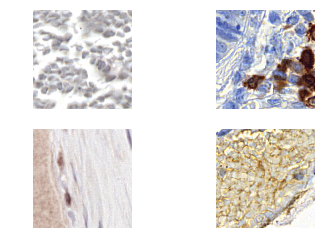

In [12]:
# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = Image.open(input_path)
    
    
    half_the_width = image.size[0] / 2
    half_the_height = image.size[1] / 2
    image = image.crop(
        (
            half_the_width - 100,
            half_the_height - 100,
            half_the_width + 100,
            half_the_height + 100
        )
    )
    
    # Convert image to the correct range
    image = np.asarray(image) / 255

    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()
    
training_paths = os.listdir(train_dir)
validation_paths = os.listdir(validation_dir)

training_images = [load_image(join(train_dir, path)) for path in training_paths[:50]]
print('Some training examples (shape {shape}):'.format(shape=training_images[0].shape))
plot_image(training_images[12:16], images_per_row=2)

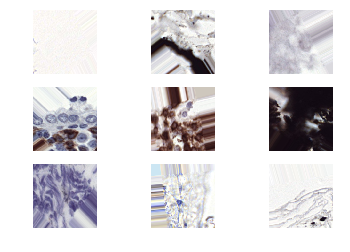

In [13]:
# define data preparation
datagen = ImageDataGenerator(rotation_range=90,
                                     horizontal_flip=True, 
                                     vertical_flip=True, 
                                     zoom_range=0.3, 
                                     width_shift_range=.3, 
                                     height_shift_range=.3)

fake_labels = np.random.rand(len(training_images))
fake_labels[fake_labels >= .5] = 1
fake_labels[fake_labels < .5] = 0

datagen.fit(training_images)

for X_batch, y_batch in datagen.flow(np.array(training_images), fake_labels, batch_size=9):
    plot_image(X_batch, images_per_row=3)
    break

## 1.4. Storing and getting patches 
Store everything in these objects to disk. TODO

In [14]:
def storepatchesondisk(patches, dirname):
    #TODO
    print('Patches stored!')

def getpatchesfromdisk(dirname):
    #TODO
    return patches

## 1.5 Upsampling
TODO
## 1.6 Calulate Centroids
And converting them to a dataframe!

In [50]:
def prepareSubmissionData(image_names, pixel_sizes, images):
    # define dataframe columns
    columns = ['image_id_roi_id', 'pixel_size','x', 'y', 'score']
   
    #create the dataframe used to store coordinates
    results = pd.DataFrame(columns=columns)
    #per image get the list of centroids
    for idx, image in enumerate(images):
        labels = skimage.measure.label(image, background=0)
        regions = skimage.measure.regionprops(labels)
        
        #for each region found, add the data to the dataframe
        for region in regions:
            
            # only select blobs that have more than 250 pixels/voxels. Arbitrary number, needs to be optimal
            if region.area >= 250:
                temp = pd.DataFrame([image_names[idx], pixel_sizes[idx], region.centroid[0],region.centroid[1],region.centroid[2]], columns=columns)
                results.append(temp, ignore_index=True)
 
    return results

## 1.7 Define custom callbacks
TODO
* Plot loss
* early stopping

## 1.8 Custom loss function
TODO

## 1.9 Image warping with OpenCV
TODO

# Part 2 - Networks
This is where things go deep. The following two networks are defined

* A "stardard" U-net that maxes out at 512
* A copy of the U-net used to create a Retina U-net detector. Very specific approach and smaller than the standard u-net

Additionally this section contains the following:
* A method to calculate the f1-score
* A method to save intermediate best networks
* Some sanity checks: side-by-side plot of images and masks
* Generating suitable training images
* Model compilation 
* Model training

### 2.1 U-net architecture

In [16]:
def get_unet(img_rows=512, img_cols=512, channels=3):
    # A common problem is that Keras might automatically detect "Channels first" or last. The below notation is "Channels last"
    # Which seems to be the default on cartesius. Problem, we only have once channel if we opt to only use the green channel
    #
    # Regarding input layer size - this does not seem to be our problem (Keras docs):
    # When using this layer as the first layer in a model, provide the keyword argument input_shape (tuple of integers,
    # does not include the sample axis), e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures in 
    # data_format="channels_last".
    
    # So flattening also does not force the data into our format (e.g. by using a Flatten() layer)
    
    # Our error seems to be related to https://github.com/keras-team/keras/issues/6351 which includes many miracle fixes
    # yet nothing for us.
    
    inputs = Input(shape=(img_rows, img_cols, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
 
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    model = Model(inputs=inputs, outputs=conv10)
    # we need to punish overfitting on background harshly until our model improves. Dice coef seems to get used often 
    # in literature, and kaggle. Using binary crossentropy for the moment. Before we were using categorical crossentropy
    
    sgd = keras.optimizers.SGD(lr=0.01) # Zanetta used 0.05, ours gets stuck in a local minimum and never improves. Probably related to training samples #
    # however, we are now encountering this: a never changing loss and val_loss. 
    # https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

## 2.2 Even Deeper U-net
This one goes down to 1024.

In [17]:
def get_secondunet(img_rows=512, img_cols=512, channels=3):
    # Deeper I go, deeper down
    # Didn't think it could get any
    # blacker
    # The cold bites, the pressure
    # builds
    # I think I no longer matter
    # https://www.youtube.com/watch?v=1-506_jiYkA
    
    inputs = Input(shape=(img_rows, img_cols, channels))
    s = keras.layers.core.Lambda(lambda x: x / 255) (inputs)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #512
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    #1024
    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool5)
    conv6 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv6)
    
    #512 again
    up7 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6), conv5], axis=3)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7), conv4], axis=3)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8), conv3], axis=3)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv9)

    up10 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9), conv2], axis=3)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up11 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10), conv1], axis=3)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv11)
 
    conv12 = Conv2D(1, (1, 1), activation='sigmoid')(conv11)
    model = Model(inputs=inputs, outputs=conv12)
    # we need to punish overfitting on background harshly until our model improves. Dice coef seems to get used often 
    # in literature, and kaggle. Using binary crossentropy for the moment. Before we were using categorical crossentropy
    
    # Zanetta used a lr of 0.05, ours gets stuck in a local minimum and never improves. Probably related to training samples #
    # however, we are now encountering this: a never changing loss and val_loss. 
    # https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

Network parameters, from Francesco's paper:

* LR = 0.05
* Dropouts 0.5 (when?)
* SGD
* CCR (cross-entropy) loss
* F1-score

* RGB threshold on training imgs

Also 10 epochs with batch size 1. x20 resolution and 128x128 in- and output size 

## 2.3 F1-score
f1-score based on what we had in week 7 or 8. Not used at the moment


In [18]:
def f1_score(y_true, y_pred):
    # Compute precision, recall and obtain several detection thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    
    # Compute F1-score and remove numerical problems
    f1 =  2 * (precision * recall) / (precision + recall)
    f1 = f1[~np.isnan(f1)]
    
    return f1

## 2.4 Sanity check: plotting a patch and a corresponding mask

(300, 512, 512, 3)
(300, 512, 512, 3)


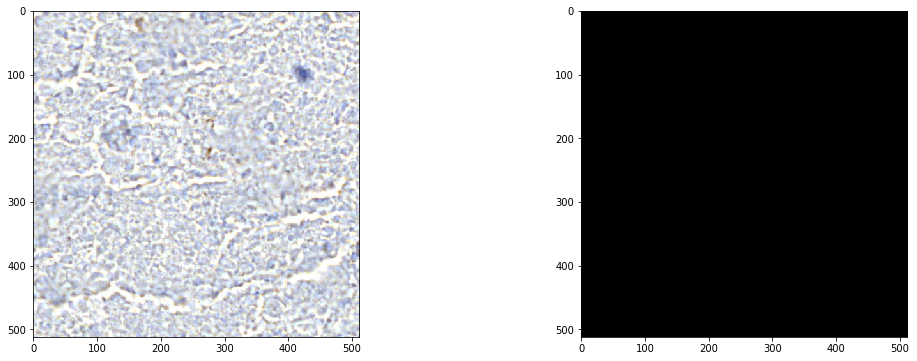

In [19]:
print(np.asarray(img_patches).shape) #should be (num_samples, 512, 512, 3)
print(np.asarray(mask_patches).shape) #should be (num_samples, 512, 512)
ino = 3

plt.figure(1, figsize=(18, 6))
# for the record, matplotlib uses this short-hand notation to show subplots. The 121 here stands for 1 row, 2 columns, first img
# now you know how to use subplots like a pro.
plt.subplot(121)
plt.imshow(img_patches[ino])

plt.subplot(122)
plt.imshow(mask_patches[ino])

## 2.5 compile model and print model architecture. 
Also defines a model_checkpoint callback.

In [20]:
model = get_secondunet(512, 512, num_channels)
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 896         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

## 2.6 Prepare X_train and y_train sets
* X_train contains the training samples (RGB)
* y_train contains the labels as a binary map. Since the masks are generated as a 3-channel image earlier on, we just need to delete the two extra channels.

In [21]:
X_train = []
y_train = []
for img in img_patches:
    X_train.append(np.asarray(img[:, :, :]))
for msk in mask_patches:
    y_train.append(np.asarray(msk[:, :,:]))

y_train = np.delete(y_train, 2, 3)
y_train = np.delete(y_train, 1, 3)

#sanity checks.. what sizes are we dealing with?
print(len(X_train))
print(np.shape(X_train))
print(np.shape(y_train))

300
(300, 512, 512, 3)
(300, 512, 512, 1)


## 2.7 Plot the mask again. 

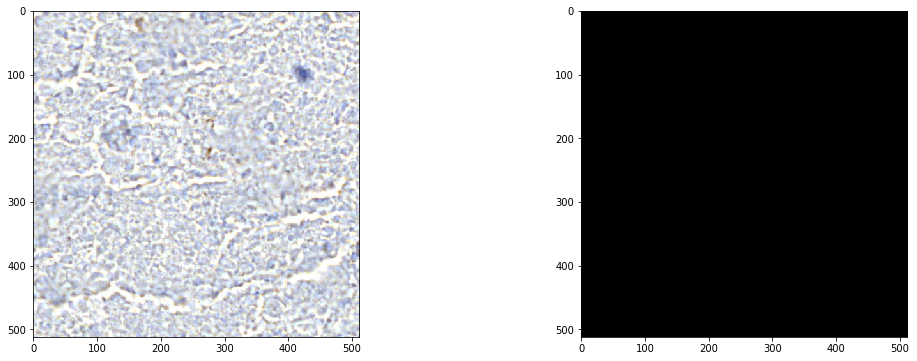

In [22]:
#intermediate level sanity checks
plt.figure(1, figsize=(18, 6))
# for the record, matplotlib uses this short-hand notation to show subplots. The 121 here stands for 1 row, 2 columns, first img
# now you know how to use subplots like a pro.
plt.subplot(121)
plt.imshow(img_patches[ino])

plt.subplot(122)
plt.imshow(np.squeeze(y_train[ino]), cmap='gray')

## 2.8 Finally train the model
Train the model. If all goes well...

In [23]:
# One epoch generally takes 1 minute with batch size 1, 200 samples. Something to keep in mind..
# the issues with the steady loss and val_loss seem to be related to the so-called dying relu problem. Go figure. Another problem to solve!
# model.fit_generator(imgs_train, imgs_mask_train, batch_size=1, nb_epoch=10, verbose=1, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint])
model.fit(np.array(X_train), y_train, batch_size=8, epochs=20, verbose=1, shuffle=True, validation_split=0.2, callbacks=[model_checkpoint])

Train on 240 samples, validate on 60 samples
Epoch 1/1
240/240 [==============================] - 86s 358ms/step - loss: -0.3097 - acc: 0.8736 - val_loss: -8.2566 - val_acc: 0.9198


# Part 3 - Using the Validation set for a sanity check
The below code does the following things:

* Load the best-yet model 

* load the validation images we've been supplied with
* Generate masks for the validation images
    * Creates a validation_masks_dir if there is none yet.
    * Creates validation masks or loads them
    * Creates patches for the validation set
* Show side-by-side plots of the original validation image and the new mask

* Shove one image in our best model and ask predict() what it makes out of it
    * apply a threshold to the image
* Plot the orgininal image, the defined mask, and the prediction side-by-side

## 3.1 Load the best model

In [24]:
# load our best model
model1 = keras.models.load_model('weights.h5') #saved by our callback earlier

## 3.2 Generate masks for the validation set

In [25]:
# if it does not exist already, create the validation masks folder
validation_paths = os.listdir(validation_dir)
if os.path.exists(validation_masks_dir):
    pass
else:
    os.system('mkdir -p ' + validation_masks_dir)

# generate the masks if they are not already present on the system.
mask_paths = os.listdir(validation_masks_dir)

print('Found {} validation images.'.format(len(validation_paths))) # How many images do we actually have?

for idx, path in enumerate(validation_paths):
    mask_name = path.split('.png')[0] + '_mask.png'
    if mask_name not in mask_paths:
        print('Currently at image {}'.format(idx))
        createMaskForImage(validation_dir, path, validation_points, validation_masks_dir, createCircularMask)

Found 78 validation images.


## 3.3 Generate patches for the validation set

In [26]:
vpatches = generate_patches(validation_dir, validation_masks_dir, 20, 512, 512)
vmask_patches = []
vimg_patches = []
for patch in vpatches:
    vimg_patches.append(np.array(patch[0]))
    vmask_patches.append(np.array(patch[1]))

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/hpc/sw/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


1: (512, 512, 3)  image: 1079_CD3_ROI_5_mask.png
1: (512, 512, 3)  mask:  1079_CD3_ROI_5.png
2: (512, 512, 3)  image: 1079_CD3_ROI_3_mask.png
2: (512, 512, 3)  mask:  1079_CD3_ROI_3.png
3: (512, 512, 3)  image: T17-071827_III6_CD-8_ROI_2_mask.png
3: (512, 512, 3)  mask:  T17-071827_III6_CD-8_ROI_2.png
4: (512, 512, 3)  image: T17-071827_III6_CD-8_ROI_9_mask.png
4: (512, 512, 3)  mask:  T17-071827_III6_CD-8_ROI_9.png
5: (512, 512, 3)  image: 27_CD3_ROI_11_mask.png
5: (512, 512, 3)  mask:  27_CD3_ROI_11.png
6: (512, 512, 3)  image: T17-071827_III6_CD-8_ROI_11_mask.png
6: (512, 512, 3)  mask:  T17-071827_III6_CD-8_ROI_11.png
7: (512, 512, 3)  image: T17-071840_III5_CD3_ROI_14_mask.png
7: (512, 512, 3)  mask:  T17-071840_III5_CD3_ROI_14.png
8: (512, 512, 3)  image: 23-CD8_ROI_2_mask.png
8: (512, 512, 3)  mask:  23-CD8_ROI_2.png
9: (512, 512, 3)  image: 27_CD3_ROI_3_mask.png
9: (512, 512, 3)  mask:  27_CD3_ROI_3.png
10: (512, 512, 3)  image: 1079_CD3_ROI_1_mask.png
10: (512, 512, 3)  mask: 

In [27]:
val_images_p = []
for img in vimg_patches:
    val_images_p.append(np.asarray(img[:, :, :]))
    
#sanity checks.. what sizes are we dealing with?
print(len(val_images_p))
print(np.shape(val_images_p))

20
(20, 512, 512, 3)


## 3.4 Check patches and masks from the validation set

(512, 512, 3)


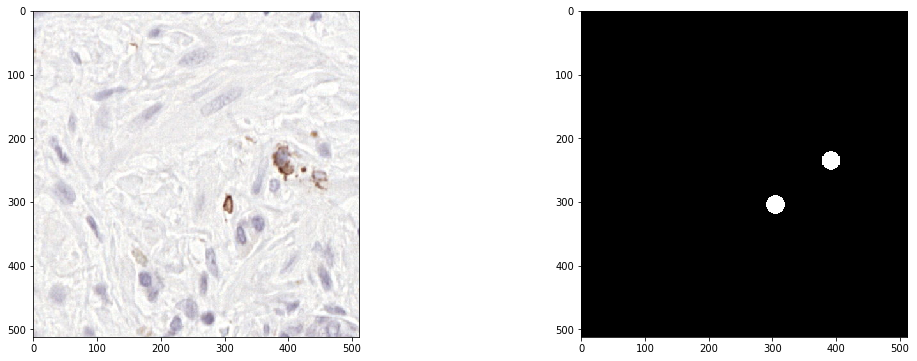

In [28]:
#show validation image and it's mask - Another sanity check
plt.figure(1, figsize=(18, 6))

plt.subplot(121)
print(vimg_patches[0].shape)
plt.imshow(vimg_patches[3])

plt.subplot(122)
plt.imshow(vmask_patches[3])

## 3.5 Make a prediction!

In [29]:
# Make some predictions
preds_val = model.predict(np.asarray(val_images_p), verbose=1)

20/20 [==============================] - 8s 397ms/step


## 3.6 Threshold prediction
May need to find a better way to do this at some point..

In [30]:
print(np.amin(preds_val)) # prints min
print(np.ptp(preds_val)) # prints range
print(np.amax(preds_val)) # prints max

0.000159697
0.99984
1.0


In [31]:
# threshold prediction
preds_val = np.squeeze(preds_val) 
preds_val_t = (preds_val > 0.5)*1.0

In [32]:
print(np.amin(preds_val_t)) # prints min
print(np.ptp(preds_val_t)) # prints range
print(np.amax(preds_val_t)) # prints max

0.0
1.0
1.0


## 3.7 Checking prediction output

In [33]:
#sanity check for checking image size
print(np.shape(vimg_patches[0]))
print(np.shape(preds_val[0])) 
print(np.shape(preds_val_t[0]))

(512, 512, 3)
(512, 512)
(512, 512)


(512, 512, 3)
(512, 512, 3)
(512, 512)


/hpc/sw/python-3.5.2/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


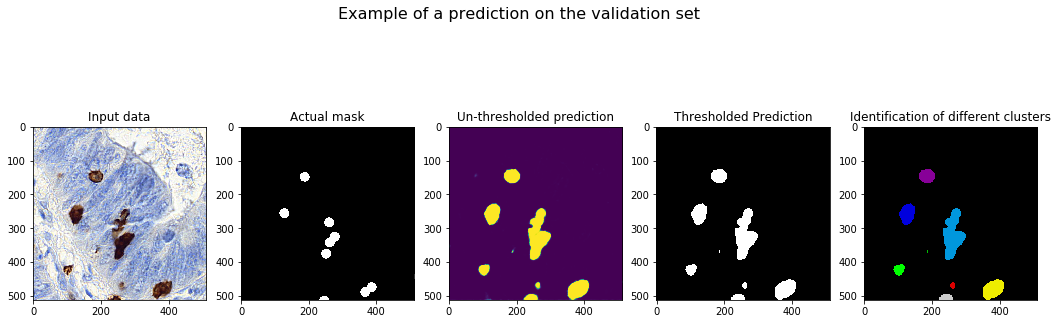

In [58]:
# create a subplot of 1 row
plt.figure(1, figsize=(18, 6))
plt.suptitle('Example of a prediction on the validation set', fontsize=16)

idx = 7 

# plot original image
plt.subplot(151)
print(vimg_patches[idx].shape)
plt.imshow(vimg_patches[idx])
plt.title('Input data')

#plot what the mask should have been
plt.subplot(152)
print(vmask_patches[idx].shape)
plt.imshow(vmask_patches[idx])
plt.title('Actual mask')

#plot raw, unthresholded prediction
plt.subplot(153)
print(preds_val[idx].shape)
plt.imshow(preds_val[idx])
plt.title('Un-thresholded prediction')

#plot thresholded prediction
plt.subplot(154)
plt.imshow(preds_val_t[idx], cmap='gray')
plt.title('Thresholded Prediction')

#plot labels using the measure tools
from skimage.measure import label, regionprops

# what this does is label the different blobs based on the connected component principle
labels = label(preds_val_t[idx], background=0)

# it should show even the tiniest specks as different blobs, this is of course undesirable because these are false positives!
plt.subplot(155)
plt.imshow(labels, cmap='spectral')
plt.title('Identification of different clusters')

## 3.8 Prediction on the entire test set
TODO

In [62]:
#just another validation of what we're seeing
regions = regionprops(labels)

for region in regions:
    print('Number of pixels in blob: '+ format(region.area))
    print('centroid coordinates of blob: '+format(region.centroid))

Number of pixels in blob: 1586
centroid coordinates of blob: (147.12610340479193, 185.15762925598992)
Number of pixels in blob: 2172
centroid coordinates of blob: (257.88259668508289, 127.37707182320442)
Number of pixels in blob: 5918
centroid coordinates of blob: (319.85569449138222, 260.92801622169651)
Number of pixels in blob: 3
centroid coordinates of blob: (354.0, 0.0)
Number of pixels in blob: 28
centroid coordinates of blob: (368.82142857142856, 186.28571428571428)
Number of pixels in blob: 867
centroid coordinates of blob: (421.95386389850057, 103.10265282583622)
Number of pixels in blob: 2769
centroid coordinates of blob: (480.13073311664863, 379.38497652582157)
Number of pixels in blob: 2
centroid coordinates of blob: (458.5, 511.0)
Number of pixels in blob: 233
centroid coordinates of blob: (468.72103004291847, 261.08154506437768)
Number of pixels in blob: 619
centroid coordinates of blob: (503.64781906300487, 241.37318255250403)


## 3.9 Writing results to disk
TODO

In [36]:
# make dir for results
result_dir = 'Results'
# Create directory for the results (if not already existing)
if os.path.exists(result_dir):
    pass
else:
    os.system('mkdir -p ' + result_dir)

## 3.10 Preparing a submission
TODO using the code provided. We need to decide how we are going to find the centroid. I think Francesco has more knowledge on algorithms for this.

In [37]:
#todo

# Part 4 - Evaluation on the test set

## 4.1 training on the training + validation set
More data is more better. Lets take the validation set as training data for our final model and using a split of 0.1 or 0.2?

Also worth to be considered is training on full images!

## 4.2 Loading test images
TODO

## 4.3 Make predictions on the test images
TODO

## 4.4 Store test prediction images
TODO

## 4.5 Calculate Lymphocyte centroids
TODO

## 4.6 Convert predictions to a csv submission
TODO

# Part 5 - What is outside the flow of work
Counting the number of lymphocytes was the goal of the project although the evaluation is based on the precision of the network. Therefore the following method returns the number of lymphocytes, given a sample image. 

## 5.1 Counting Lymps

In [38]:
# function to count the number of lymphocytes in a given image
def count_lymps(image):
    num = skimage.measure.label(image,  return_num=True)[1]
    return num

In [39]:
# and other things that come up

## 5.999 Print the time needed to execute the entire notebook

In [40]:
print("--- The entire notebook was done in %s seconds ---" % (time.time() - start_time))

--- The entire notebook was done in 333.5082287788391 seconds ---
